## ASPLOS 2023 Code Sample - Training and Testing Demo of 5-layer DONNs and 30-layer DONNs

### DONNs setups definition (visible range laser input)

```bash
wavelength = laser wavelenght (unit: meter)
pixel_size = pixel size of phase mask (unit: meter)
distance = diffraction distance (unit: meter)
depth = number of layers
```

### DONNs setups training

```bash
batch_size = batch size (500)
lr = learning rate (0.1)
epochs = number of training iterations (5)
amp_factor = regularization factor (2)
```
====================================================

In [1]:
wavelength = 5.32e-7
pixel_size = 0.000036
sys_size=200
distance=0.3
pad=50
depth=5
amp_factor=1.5
batch_size=500
lr=0.08
epochs=10

In [2]:
import os,csv,random
from time import time
import pathlib, argparse
import numpy as np

from tqdm import tqdm

import pandas as pd
import torch, torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle

### Loading LightRidge Package

In [3]:
import lightbridge.data as dataset
import lightbridge.layers as layers
import lightbridge.utils as utils
import lightbridge.models as models 
device="cuda:0"

/home/cunxi/.conda/envs/rl/lib/python3.7/site-packages/lightbridge-0.1.7-py3.7.egg/lightbridge/get_h.py:27: UserWarning: 
**************************** WARNING ***********************
LightPipes: Cannot import pyFFTW, falling back to numpy.fft.
(Try to) install pyFFTW on your computer for faster performance.
Enter at a terminal prompt: python -m pip install pyfftw.
Or reinstall LightPipes with the option pyfftw
Enter: python -m pip install lightpipes[pyfftw]

You can suppress warnings by using the -Wignore option:
Enter: python _Wignore *****.py
*************************************************************


In [4]:
print("training and testing on MNIST10 dataset")
load_dataset = dataset.load_dataset(batch_size = batch_size, system_size = sys_size, datapath = "./data")
train_dataloader, val_dataloader = load_dataset.MNIST()

training and testing on MNIST10 dataset


In [5]:
model = models.DiffractiveClassifier_Raw(wavelength=wavelength, pixel_size=pixel_size, 
                                         sys_size=sys_size, distance=distance, pad = pad, 
                                         num_layers=depth, amp_factor=amp_factor, approx="Fresnel").to(device)


Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation


In [6]:
def train(model,train_dataloader, val_dataloader):        
    criterion = torch.nn.MSELoss(reduction='sum').cuda()
    print('training starts.')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20, gamma=0.5)
    for epoch in range(epochs):
        log = [epoch]
        model.train()
        train_len, train_running_counter, train_running_loss = 0.0, 0.0, 0.0
        tk0 = tqdm(train_dataloader, ncols=105, total=int(len(train_dataloader)))
        for train_iter, train_data_batch in enumerate(tk0):
            train_images, train_labels = utils.data_to_cplex(train_data_batch, device=device)
            train_outputs = model(train_images)
            train_loss_ = criterion(train_outputs, train_labels)
            train_counter_ = torch.eq(torch.argmax(train_labels, dim=1), torch.argmax(train_outputs, dim=1)).float().sum()
           
            optimizer.zero_grad()
            train_loss_.backward(retain_graph=True)
            optimizer.step()
            train_len += len(train_labels)
            train_running_loss += train_loss_.item()
            train_running_counter += train_counter_

            train_loss = train_running_loss / train_len
            train_accuracy = train_running_counter / train_len

            tk0.set_description_str('Epoch {}/{} : Training'.format(epoch, epochs-1))
            tk0.set_postfix({'Train_Loss': '{:.2f}'.format(train_loss), 'Train_Accuracy': '{:.5f}'.format(train_accuracy)})
        scheduler.step()
        log.append(train_loss)
        log.append(train_accuracy)

        val_loss, val_accuracy = eval(model, val_dataloader)
        log.append(val_loss)
        log.append(val_accuracy)
    return train_loss, train_accuracy, val_loss, val_accuracy, log 

In [7]:
def eval(model, val_dataloader):
    criterion = torch.nn.MSELoss(reduction='sum').cuda()
    with torch.no_grad():
        model.eval()
        val_len,val_running_counter,val_running_loss = 0.0, 0.0, 0.0
        tk1 = tqdm(val_dataloader, ncols=105, total=int(len(val_dataloader)))
        for val_iter, val_data_batch in enumerate(tk1):
            val_images, val_labels = utils.data_to_cplex(val_data_batch,device=device)
            val_outputs = model(val_images)

            val_loss_ = criterion(val_outputs, val_labels)
            val_counter_ = torch.eq(torch.argmax(val_labels, dim=1), torch.argmax(val_outputs, dim=1)).float().sum()

            val_len += len(val_labels)
            val_running_loss += val_loss_.item()
            val_running_counter += val_counter_

            val_loss = val_running_loss / val_len
            val_accuracy = val_running_counter / val_len

            tk1.set_description_str('Validating')
            tk1.set_postfix({'Val_Loss': '{:.5f}'.format(val_loss), 'Val_Accuarcy': '{:.5f}'.format(val_accuracy)})
    return val_loss, val_accuracy

In [8]:
train(model, train_dataloader, val_dataloader)


  0%|                                                                            | 0/120 [00:00<?, ?it/s]

training starts.


Validating: 100%|████████████████| 20/20 [00:02<00:00,  6.70it/s, Val_Loss=0.06989, Val_Accuarcy=0.95520]


(0.05839517704645793,
 tensor(0.9643, device='cuda:0'),
 0.06988576526641846,
 tensor(0.9552, device='cuda:0'),
 [9,
  0.05839517704645793,
  tensor(0.9643, device='cuda:0'),
  0.06988576526641846,
  tensor(0.9552, device='cuda:0')])

# 1 Epoch = 21 seconds

## Visualize Post-training Phase Parameters (weights of DONNs) using LightRidge

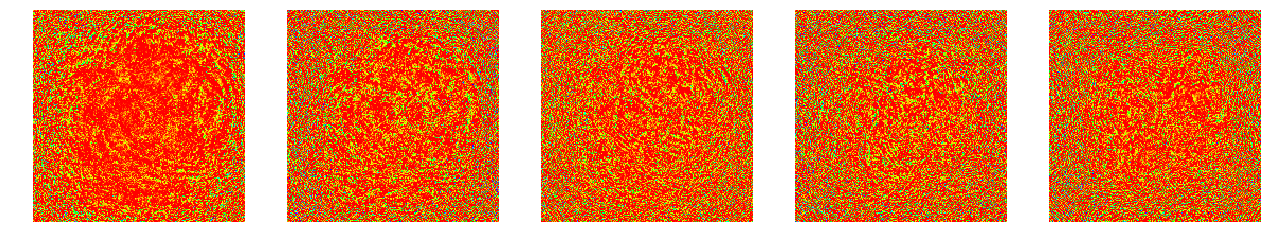

In [9]:
model.phase_view(None)

## Visualize Inference (Forward) of DONNs using LightRidge


  0%|                                                                           | 0/2500 [00:00<?, ?it/s]

0
7 torch.Size([200, 200])
1
7 torch.Size([200, 200])
2
7 torch.Size([200, 200])
3
7 torch.Size([200, 200])


  0%|                                                                           | 0/2500 [00:03<?, ?it/s]


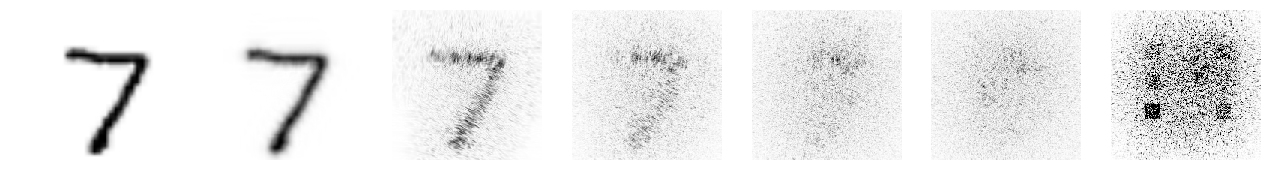

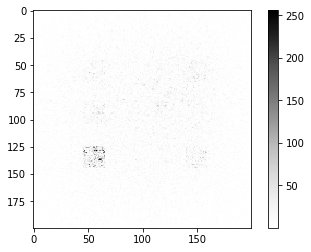

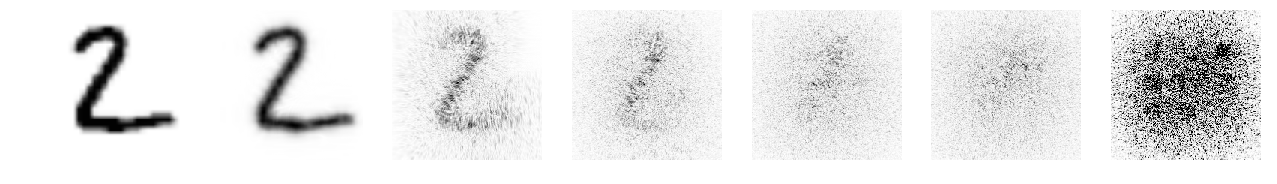

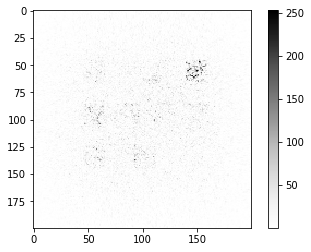

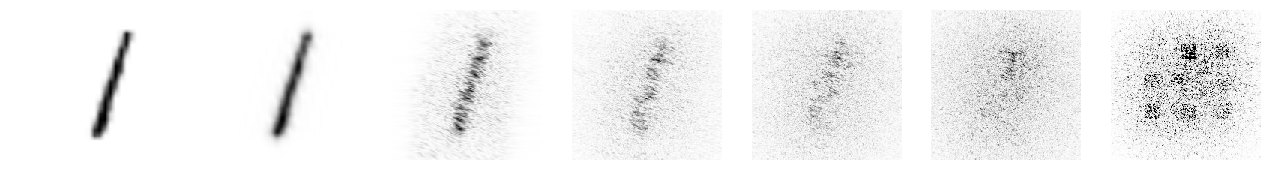

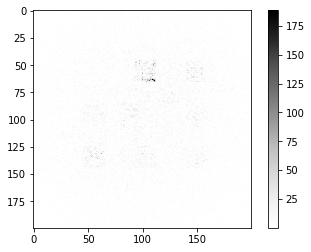

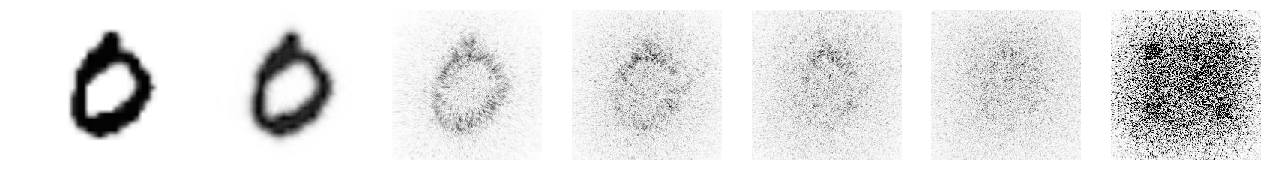

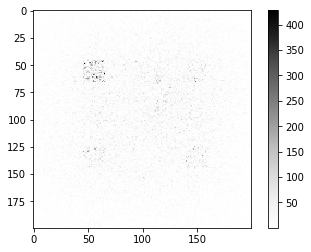

In [10]:
load_dataset = dataset.load_dataset(batch_size = 4, system_size = sys_size, datapath = "./data")
train_dataloader, val_dataloader = load_dataset.MNIST()
with torch.no_grad():
    model.eval()
    tk1 = tqdm(val_dataloader, ncols=105, total=int(len(val_dataloader)))
    for val_iter, val_data_batch in enumerate(tk1):
        val_images, val_labels = utils.data_to_cplex(val_data_batch,device=device)
        val_outputs = model.prop_view(val_images)
        break

## 30-layer DONNs training demonstration 

In [15]:
wavelength = 5.32e-7
pixel_size = 0.000036
sys_size=200
distance=0.3
pad=50
depth=30 # 30 layers now
amp_factor=1
batch_size=100
lr=0.08
epochs=1

In [16]:
print("training and testing on MNIST10 dataset")
load_dataset = dataset.load_dataset(batch_size = batch_size, system_size = sys_size, datapath = "./data")
train_dataloader, val_dataloader = load_dataset.MNIST()

training and testing on MNIST10 dataset


# Note that we include 30-layer model training for 1 epoch to show the scalability of the framework (runtime). The performance of this model needs further exploration in training parameters.

In [17]:
model30 = models.DiffractiveClassifier_Raw(wavelength=wavelength, pixel_size=pixel_size, 
                                         sys_size=sys_size, distance=distance, pad = pad, 
                                         num_layers=depth, amp_factor=amp_factor, approx="Fresnel").to(device)


Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fr

In [19]:
train(model30, train_dataloader, val_dataloader)


  0%|                                                                            | 0/600 [00:00<?, ?it/s]

training starts.


Validating: 100%|██████████████| 100/100 [00:08<00:00, 12.21it/s, Val_Loss=0.37452, Val_Accuarcy=0.87600]


(0.39306323769887286,
 tensor(0.8487, device='cuda:0'),
 0.3745199937820435,
 tensor(0.8760, device='cuda:0'),
 [0,
  0.39306323769887286,
  tensor(0.8487, device='cuda:0'),
  0.3745199937820435,
  tensor(0.8760, device='cuda:0')])

# 1.5 min for one epoch.